In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import DenseNet121

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255, 
    # rotation_range = 5,
    # zoom_range = (0.90, 0.90),
    # brightness_range = (0.95, 0.95),
    # horizontal_flip = True,
    # vertical_flip = True,
    data_format = 'channels_last',
    validation_split = 0.2,
    dtype = tf.bfloat16
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/AlzheimersDataset/train',
    target_size = (224, 224),
    batch_size = (32),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    seed = 123
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/AlzheimersDataset/train',
    target_size = (224, 224),
    batch_size = (32),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation',
    seed = 123
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [ ]:
datagen2 = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 5,
    zoom_range = (0.90, 0.90),
    brightness_range = (0.95, 0.95),
    horizontal_flip = True,
    vertical_flip = True,
    data_format = 'channels_last',
    validation_split = 0.0,
    dtype = float
)

test_generator = datagen2.flow_from_directory(
    '/content/drive/MyDrive/AlzheimersDataset/test',
    target_size = (224, 224),
    batch_size = (4),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    seed = 123
)

Found 1279 images belonging to 4 classes.


In [ ]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.layers

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC', 'accuracy', 'Recall', 'Precision'])

In [ ]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=100, callbacks=[es])

Epoch 1/100
129/129 [==============================] - 34s 198ms/step - loss: 0.9582 - auc: 0.8569 - accuracy: 0.6118 - recall: 0.5361 - precision: 0.6537 - val_loss: 1.0484 - val_auc: 0.7956 - val_accuracy: 0.4936 - val_recall: 0.3920 - val_precision: 0.5616
Epoch 2/100
129/129 [==============================] - 19s 146ms/step - loss: 0.5615 - auc: 0.9475 - accuracy: 0.7775 - recall: 0.7184 - precision: 0.8201 - val_loss: 1.0614 - val_auc: 0.8034 - val_accuracy: 0.5103 - val_recall: 0.4096 - val_precision: 0.5860
Epoch 3/100
129/129 [==============================] - 19s 148ms/step - loss: 0.4824 - auc: 0.9614 - accuracy: 0.8114 - recall: 0.7609 - precision: 0.8473 - val_loss: 0.9441 - val_auc: 0.8401 - val_accuracy: 0.5670 - val_recall: 0.4761 - val_precision: 0.6118
Epoch 4/100
129/129 [==============================] - 19s 150ms/step - loss: 0.3703 - auc: 0.9797 - accuracy: 0.8721 - recall: 0.8380 - precision: 0.8985 - val_loss: 0.9610 - val_auc: 0.8436 - val_accuracy: 0.5611 - val

In [ ]:
model.evaluate(validation_generator)

32/32 [==============================] - 4s 125ms/step - loss: 0.8350 - auc: 0.9065 - accuracy: 0.6872 - recall: 0.6725 - precision: 0.6964


[0.8349539041519165,
 0.9064956307411194,
 0.6871945261955261,
 0.67253178358078,
 0.6963562965393066]

In [ ]:
y_pred = model.predict(validation_generator)

In [ ]:
validation_generator.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
confusion_matrix(validation_generator.classes, np.argmax(y_pred, axis=1))

array([[ 17,   1,  83,  42],
       [  0,   0,   5,   5],
       [ 53,   4, 298, 157],
       [ 33,   2, 205, 118]])

In [ ]:
print(classification_report(validation_generator.classes, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.17      0.12      0.14       143
           1       0.00      0.00      0.00        10
           2       0.50      0.58      0.54       512
           3       0.37      0.33      0.35       358

    accuracy                           0.42      1023
   macro avg       0.26      0.26      0.26      1023
weighted avg       0.40      0.42      0.41      1023



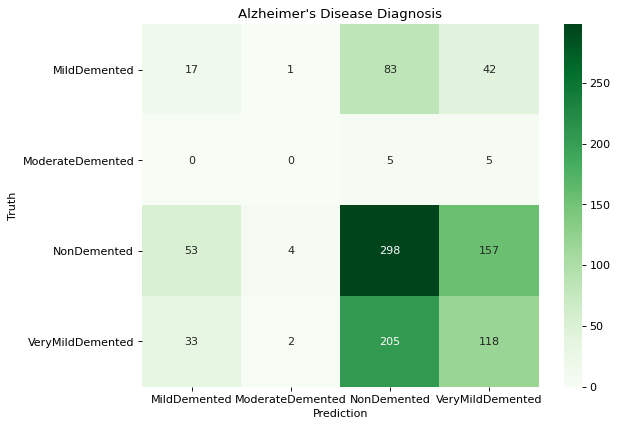

In [ ]:
CLASSES = [ 'MildDemented',
            'ModerateDemented',
            'NonDemented',
            'VeryMildDemented']

conf_arr = confusion_matrix(validation_generator.classes, np.argmax(y_pred, axis=-1))

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)